In [ ]:
!gdown 1kJAVlUa5FhxKgl3YJSs6EFK8C_4bBv4N
!unzip LG4000.zip

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import csv
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_size = 224

#Reading training data

<ul>
<li>Eye:       2 </li>
<li>Gender:    2 </li>
<li>Race:      4 ['Asian' 'Black' 'Other' 'White']</li>
<li>Contacts:  3 ['Cosmetic' 'No' 'Yes']</li>
</ul>

In [3]:
def mapped_labels(eye, gender, race, contacts):
    eye_labels     = {'Left': 0, 'Right': 1}
    gender_labels  = {'Male': 0, 'Female': 1}
    race_labels    = {'Asian': 0, 'Black': 1, 'Other': 2, 'White': 3}
    contact_labels = {'Cosmetic': 0, 'No': 1, 'Yes': 2}

    return eye_labels[eye], gender_labels[gender], race_labels[race], contact_labels[contacts]

In [42]:
train_imgs = []
train_labels = []
train_labels_position = []

csvreader = None
with open(f"/content/LG4000/train.csv", "r") as file:
    csvreader = list(csv.reader(file))

csvreader.pop(0) # Removing the header line of the file

for row in csvreader:
    eye      = row[2]
    gender   = row[3]
    race     = row[4]
    contacts = row[5]
    eye, gender, race, contacts = mapped_labels(eye, gender, race, contacts)

    img_path = "/content/LG4000/images/" + row[0] + ".tiff"
    img = img_to_array(load_img(img_path, target_size=(img_size,img_size))) / 255.
    train_imgs.append(img)

    train_labels.append([eye, gender, race, contacts])
    train_labels_position.append([row[6], row[7], row[8]])

del csvreader

train_labels = (np.array(train_labels).astype(np.int32)).T
train_labels_position = np.array(train_labels_position).astype(np.int32)
train_imgs = np.array(train_imgs).astype(np.float32)

print(train_labels.shape, train_imgs.shape)

(4, 3000) (3000, 224, 224, 3)


#Building the model

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy, Huber
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.api._v2.keras import activations
from keras.callbacks import Callback, ModelCheckpoint

In [43]:
def build_model():
    shape = (img_size, img_size, 3)
    input_layer = Input(shape = shape)

    #Fine tuning did not show any significant improvement
    vgg = VGG16(include_top = False, weights='imagenet')
    for layer in vgg.layers:
        layer.trainable = False

    vgg           = vgg(input_layer)
    batch         = BatchNormalization()(vgg)
    globalPooling = GlobalAveragePooling2D()(batch)

    #Dense Layer 1
    dropout1 = Dropout(0.15, seed=2910)(globalPooling)
    dense1   = Dense(512, activation='elu')(dropout1)
    norm1    = BatchNormalization()(dense1)
    #Dense Layer 2
    dropout2 = Dropout(0.15, seed=2003)(norm1)
    dense2   = Dense(256, activation='elu')(dropout2)
    norm2    = BatchNormalization()(dense2)
    #Dense Layer 3
    dropout3 = Dropout(0.15, seed=2017)(norm2)
    dense3   = Dense(128, activation='elu')(dropout3)
    norm3    = BatchNormalization()(dense3)
    #Dense Layer 4
    dropout4           = Dropout(0.15, seed=2905)(norm3)
    dense4             = Dense(32, activation='elu')(dropout4)
    final_dense_shared = BatchNormalization()(dense4)

    # Eye identification
    eye = Dense(1, activation = "sigmoid", name='eye')(final_dense_shared)

    # Gender identification
    gender = Dense(1, activation = "sigmoid", name='gender')(final_dense_shared)

    # Race
    race = Dense(4, activation='softmax', name='race')(final_dense_shared)

    # Contacts
    contacts = Dense(3, activation='softmax', name='contacts')(final_dense_shared)

    # Position and radius of the pupil
    position_and_radius = Dense(3, name="position_and_radius")(final_dense_shared)

    new_model = Model(inputs = input_layer, outputs = [eye, gender, race, contacts, position_and_radius])

    return new_model

model = build_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_5[0][0]']             
                                                          8                                       
                                                                                                  
 batch_normalization_10 (Ba  (None, 7, 7, 512)            2048      ['vgg16[0][0]']               
 tchNormalization)                                                                                
                                                                                            

In [44]:
initial_learning_rate = 0.01
epochs = 40
batch_size = 16

final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(len(train_imgs)/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

optimizer = Adam(learning_rate = lr_schedule)

losses = {
    'eye': BinaryCrossentropy(),
    'gender': BinaryCrossentropy(),
    'race': SparseCategoricalCrossentropy(),
    'contacts': SparseCategoricalCrossentropy(),
    'position_and_radius': Huber(delta=0.125)
}

metrics = {
    'eye': 'accuracy',
    'gender': 'accuracy',
    'race': 'accuracy',
    'contacts': 'accuracy',
}

model.compile(optimizer = optimizer, loss = losses, metrics=metrics)

In [45]:
class SaveBestMeanAccuracy(Callback):
    def __init__(self, save_path):
        super(SaveBestMeanAccuracy, self).__init__()
        self.save_path = save_path
        self.best_mean_accuracy = -1

    def on_epoch_end(self, epoch, logs=None):
        mean_accuracy = (logs['val_eye_accuracy'] + logs['val_gender_accuracy'] + logs['val_contacts_accuracy']) / 3

        if mean_accuracy > self.best_mean_accuracy:
            self.best_mean_accuracy = mean_accuracy
            self.model.save_weights(self.save_path)
            print(f"Epoch {epoch+1}: Mean Accuracy improved to {round(mean_accuracy*100, 2)}. Model saved.")
        else:
            print(f"Epoch {epoch+1}: Mean Accuracy did not improve")


mean_accuracy = SaveBestMeanAccuracy('best_mean_accuracy_model.h5')

lowest_val_loss = ModelCheckpoint('lowest_val_loss.h5', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1)

In [46]:
history = model.fit(
    train_imgs,
    [train_labels[0], train_labels[1], train_labels[2], train_labels[3], [train_labels_position]],
    epochs = epochs,
    batch_size = batch_size,
    validation_split = 0.2,
    shuffle = True,
    callbacks = [lowest_val_loss, mean_accuracy]
)

Epoch 1/40
  6/150 [>.............................] - ETA: 11s - loss: 29.5518 - eye_loss: 0.5299 - gender_loss: 0.7368 - race_loss: 1.4298 - contacts_loss: 1.3599 - position_and_radius_loss: 25.4954 - eye_accuracy: 0.6875 - gender_accuracy: 0.6250 - race_accuracy: 0.4479 - contacts_accuracy: 0.4271

150/150 [==============================] - ETA: 0s - loss: 24.2358 - eye_loss: 0.2206 - gender_loss: 0.4659 - race_loss: 0.6576 - contacts_loss: 0.6934 - position_and_radius_loss: 22.1983 - eye_accuracy: 0.9142 - gender_accuracy: 0.7704 - race_accuracy: 0.7608 - contacts_accuracy: 0.6504
Epoch 1: val_loss improved from inf to 18.21984, saving model to lowest_val_loss.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: Mean Accuracy improved to 77.56. Model saved.
150/150 [==============================] - 21s 96ms/step - loss: 24.2358 - eye_loss: 0.2206 - gender_loss: 0.4659 - race_loss: 0.6576 - contacts_loss: 0.6934 - position_and_radius_loss: 22.1983 - eye_accuracy: 0.9142 - gender_accuracy: 0.7704 - race_accuracy: 0.7608 - contacts_accuracy: 0.6504 - val_loss: 18.2198 - val_eye_loss: 0.1947 - val_gender_loss: 0.8717 - val_race_loss: 0.0528 - val_contacts_loss: 0.6851 - val_position_and_radius_loss: 16.4155 - val_eye_accuracy: 0.9467 - val_gender_accuracy: 0.6433 - val_race_accuracy: 1.0000 - val_contacts_accuracy: 0.7367
Epoch 2/40
150/150 [==============================] - ETA: 0s - loss: 7.0459 - eye_loss: 0.1249 - gender_loss: 0.3877 - race_loss: 0.5343 - contacts_loss: 0.5841 - position_and_radius_loss: 5.4148 - eye_accuracy: 0.9567 - gender_accuracy: 0.8338 - race_accuracy: 0.8033 - contacts_accuracy: 0.7192
Epoch 2: val_loss improved from 18.21984 to 3.43641, saving model to lowes

In [47]:
model.save_weights("modelo.h5")

#Evaluating the model

In [49]:
import gc
try:
    del (history)
except:
    print("History already deleted")
try:
    del (train_imgs)
except:
    print("train_imgs already deleted")
try:
    del (train_labels)
except:
    print("train_labels already deleted")
try:
    del (train_labels_position)
except:
    print("train_labels_position already deleted")
gc.collect()

8006

In [50]:
test_imgs = []
test_labels = []
test_labels_position = []

csvreader = None
with open(f"/content/LG4000/verification-subject-disjoint.csv", "r") as file:
    csvreader = list(csv.reader(file))

csvreader.pop(0) # Removing the header line of the file

for row in csvreader:
    eye      = row[2]
    gender   = row[3]
    race     = row[4]
    contacts = row[5]
    eye, gender, race, contacts = mapped_labels(eye, gender, race, contacts)

    img_path = "/content/LG4000/images/" + row[0] + ".tiff"
    img = img_to_array(load_img(img_path, target_size=(img_size,img_size))) / 255.
    test_imgs.append(img)

    test_labels.append([eye, gender, race, contacts])
    test_labels_position.append([row[6], row[7], row[8]])

del csvreader

test_labels = (np.array(test_labels).astype(np.int32)).T
test_labels_position = np.array(test_labels_position).astype(np.int32)
test_imgs = np.array(test_imgs).astype(np.float32)

In [56]:
model.load_weights("best_mean_accuracy_model.h5")

In [54]:
model.load_weights("lowest_val_loss.h5")

In [60]:
model.load_weights("modelo.h5")

In [58]:
results = model.evaluate(test_imgs, [test_labels[0], test_labels[1], test_labels[2], test_labels[3], [test_labels_position]])
print("Eye accuracy:                   ", round(results[6]*100, 2), "%")
print("Gender accuracy:                ", round(results[7]*100, 2), "%")
print("Race accuracy:                  ", round(results[8]*100, 2), "%")
print("Contacts accuracy:              ", round(results[9]*100, 2), "%")
print("Pupil position and radius loss: ", round(results[5], 5))

38/38 [==============================] - 5s 131ms/step - loss: 2.7900 - eye_loss: 0.0379 - gender_loss: 0.5610 - race_loss: 0.9570 - contacts_loss: 0.8342 - position_and_radius_loss: 0.4000 - eye_accuracy: 0.9850 - gender_accuracy: 0.8183 - race_accuracy: 0.7933 - contacts_accuracy: 0.7433
Eye accuracy:                    98.5 %
Gender accuracy:                 81.83 %
Race accuracy:                   79.33 %
Contacts accuracy:               74.33 %
Pupil position and radius loss:  0.39998


In [59]:
del (test_labels)
del (test_labels_position)
del (test_imgs)
del (results)
gc.collect()

3712

#Making predictions

In [61]:
import matplotlib.patches as patches
from matplotlib import cm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import time
import random

In [62]:
try:
    del (predict_labels)
except:
    pass
try:
    del (predict_image_path)
except:
    pass

gc.collect()

predict_labels = []
predict_image_path = []

csvreader = None
with open(f"/content/LG4000/verification-subject-disjoint.csv", "r") as file:
    csvreader = list(csv.reader(file))

csvreader.pop(0) # Removing the header line of the file

for row in csvreader:
    eye      = row[2]
    gender   = row[3]
    race     = row[4]
    contacts = row[5]

    predict_image_path.append("/content/LG4000/images/" + row[0] + ".tiff")
    predict_labels.append([eye, gender, race, contacts])

del csvreader


In [ ]:
print(len(predict_image_path))

In [63]:
def process_output(output):
    eye_labels = {0: 'Left', 1: 'Right'}
    gender_labels = {0: 'Male', 1: 'Female'}
    race_labels = {0: 'Asian', 1: 'Black', 2: 'Other', 3: 'White'}
    contact_labels = {0: 'Cosmetic', 1: 'No', 2: 'Yes'}

    eye_result = eye_labels[int(round(output[0][0][0]))]
    gender_result = gender_labels[int(round(output[1][0][0]))]
    race_result = race_labels[np.argmax(output[2][0])]
    contact_result = contact_labels[np.argmax(output[3][0])]

    return [eye_result, gender_result, race_result, contact_result]


def show_image_with_circle(image_array, x_center, y_center, radius):
    # Make a copy of the input image to avoid modifying the original
    image_with_circle = np.copy(image_array)

    # Ensure the circle coordinates and radius are within the image dimensions
    x_center = int(np.clip(x_center, 0, image_with_circle.shape[1] - 1))
    y_center = int(np.clip(y_center, 0, image_with_circle.shape[0] - 1))
    radius = int(radius)

    # Draw the circle on the image
    color = (1, 0, 0)
    linewidth = 2  # Line width of the circle
    plt.imshow(image_with_circle)

    # Create a Circle patch for the circle
    circle = Circle((x_center, y_center), radius, fill=False, edgecolor=color, linewidth=linewidth)

    # Add the circle to the current axis
    plt.gca().add_patch(circle)

    plt.show()

i:  697
i:  488
i:  665
i:  344
i:  972
i:  1033
i:  941
i:  892
i:  80
i:  400
i:  697
1/1 [==============================] - 0s 19ms/step
List of predictions: Left or right eye; Gender; Race; Contacts
Model prediction:  ['Right', 'Female', 'Asian', 'No']
Expected answer:   ['Right', 'Male', 'Asian', 'No']


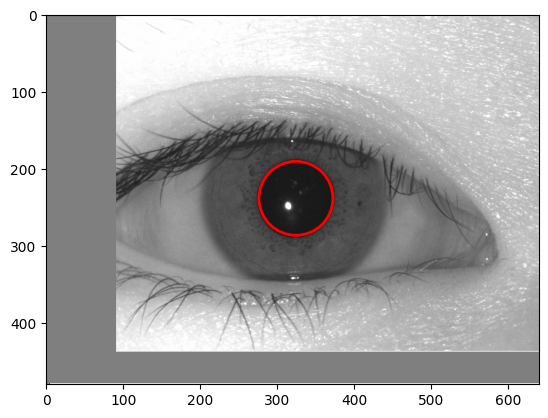



i:  488
1/1 [==============================] - 0s 21ms/step
List of predictions: Left or right eye; Gender; Race; Contacts
Model prediction:  ['Right', 'Female', 'Other', 'Yes']
Expected answer:   ['Right', 'Female', 'Other', 'No']


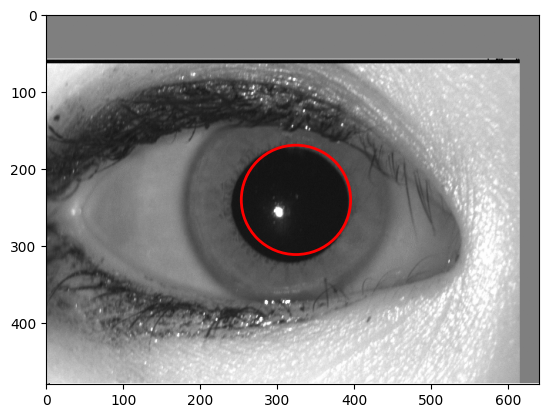



i:  665
1/1 [==============================] - 0s 19ms/step
List of predictions: Left or right eye; Gender; Race; Contacts
Model prediction:  ['Right', 'Male', 'Asian', 'No']
Expected answer:   ['Right', 'Male', 'Asian', 'No']


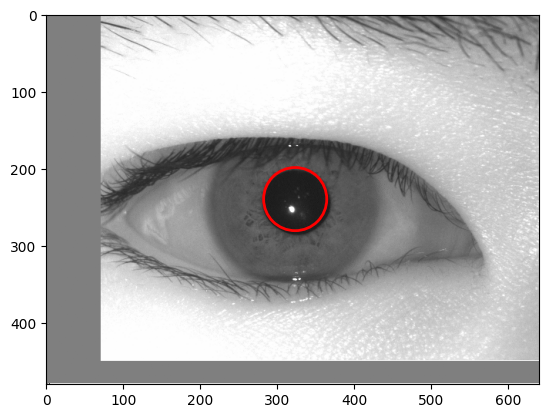



i:  344
1/1 [==============================] - 0s 19ms/step
List of predictions: Left or right eye; Gender; Race; Contacts
Model prediction:  ['Left', 'Female', 'White', 'No']
Expected answer:   ['Left', 'Female', 'Other', 'No']


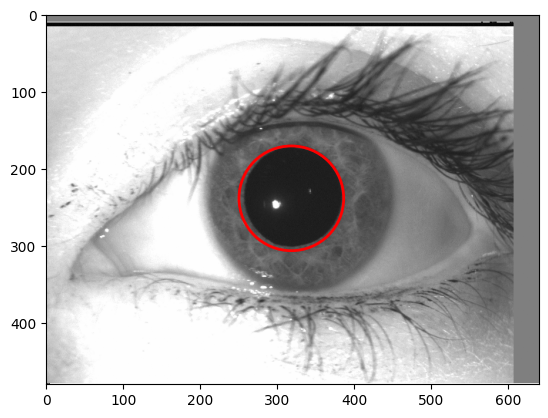



i:  972
1/1 [==============================] - 0s 20ms/step
List of predictions: Left or right eye; Gender; Race; Contacts
Model prediction:  ['Left', 'Male', 'White', 'Cosmetic']
Expected answer:   ['Left', 'Male', 'White', 'Cosmetic']


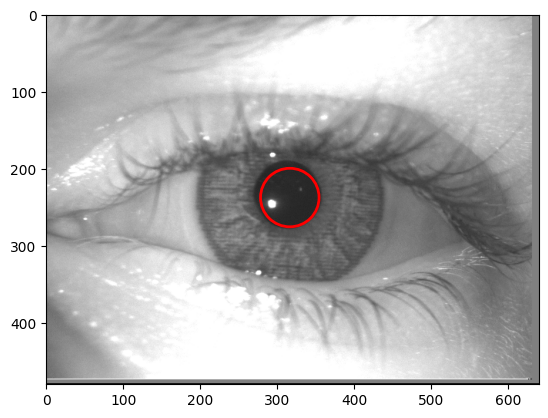



i:  1033
1/1 [==============================] - 0s 29ms/step
List of predictions: Left or right eye; Gender; Race; Contacts
Model prediction:  ['Left', 'Male', 'White', 'Cosmetic']
Expected answer:   ['Left', 'Male', 'White', 'Cosmetic']


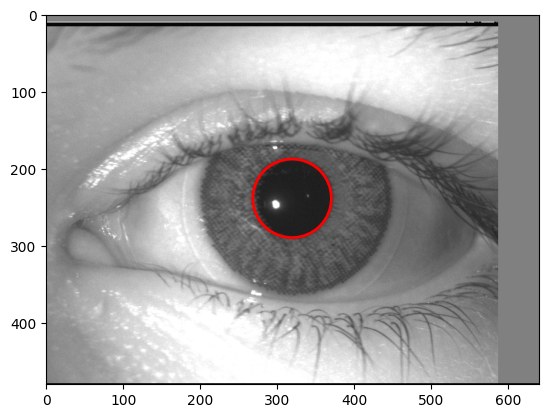



i:  941
1/1 [==============================] - 0s 27ms/step
List of predictions: Left or right eye; Gender; Race; Contacts
Model prediction:  ['Left', 'Male', 'White', 'Cosmetic']
Expected answer:   ['Left', 'Male', 'White', 'Cosmetic']


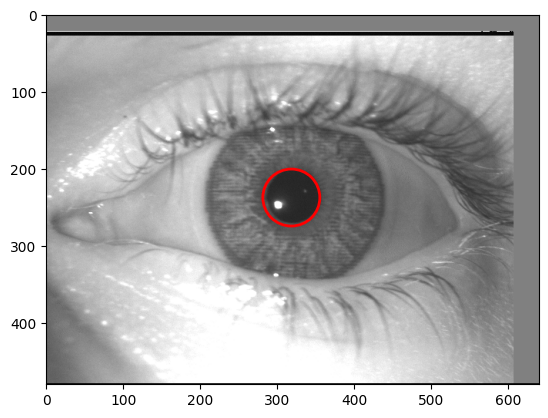



i:  892
1/1 [==============================] - 0s 18ms/step
List of predictions: Left or right eye; Gender; Race; Contacts
Model prediction:  ['Right', 'Male', 'White', 'Cosmetic']
Expected answer:   ['Right', 'Male', 'White', 'Cosmetic']


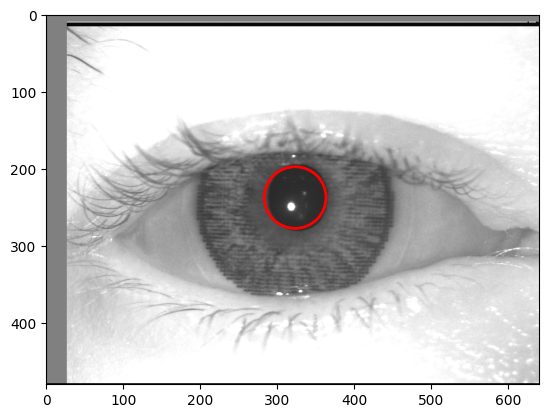



i:  80
1/1 [==============================] - 0s 19ms/step
List of predictions: Left or right eye; Gender; Race; Contacts
Model prediction:  ['Left', 'Female', 'White', 'Yes']
Expected answer:   ['Left', 'Female', 'White', 'Yes']


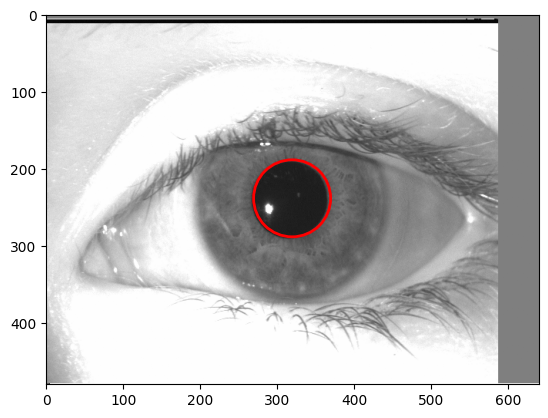



i:  400
1/1 [==============================] - 0s 18ms/step
List of predictions: Left or right eye; Gender; Race; Contacts
Model prediction:  ['Left', 'Female', 'Asian', 'No']
Expected answer:   ['Left', 'Female', 'Asian', 'No']


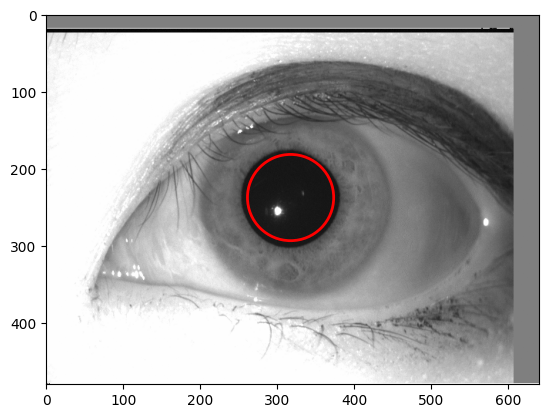



[697, 488, 665, 344, 972, 1033, 941, 892, 80, 400]


In [67]:
indexes = []
for actual_prediction in range(0,10):
    i = random.randint(0, len(predict_image_path))
    while i in indexes:
        i = random.randint(0, len(predict_image_path))
    indexes.append(i)

for i in indexes:

    print("i: ", i)

    img = img_to_array(load_img(predict_image_path[i])) / 255. #This is the image that will be shown

    img_prediction = img_to_array(load_img(predict_image_path[i],  target_size=(img_size,img_size))) / 255. #This is the image that will go to the NN
    temp = np.array([img_prediction])

    predicao = (model.predict(temp))

    print("List of predictions: Left or right eye; Gender; Race; Contacts")
    print("Model prediction: ",process_output(predicao))
    print("Expected answer:  ",predict_labels[i])

    position = predicao[4][0]
    x = position[0]
    y = position[1]
    radius = position[2]

    show_image_with_circle(img, x, y, radius)

    print("==============================================\n\n")

print(indexes)